# MLP for image classification

In this notebook we are going to learn how to use a Multi-Layer Perceptron (MLP) (Fully-Connected, Feed-Forward Network) for classifying images.

An MLP like the ones you used in the notebook of last week can be used with any kind of input data if we can represent it as a vector of real numbers. The shape of the input vector determines the size of the first layer in the model.

In the case of images (2D arrays of pixel values) we can get fixed-length vectors by: (1) using always images of the same size, and (2) flatenning the images into a 1D array. The flatten operation collapses an array into one dimension. For example, if we have a grayscale image of $28\times28$ pixels, its flattened version is a 1d array of $784$ pixel values. Now we can fed these $784$ values into a MLP for classifiying the image.

### Import the necessary libraries

In [1]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Use GPU if available

In [2]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The Fashion-MNIST dataset

[**Fashion-MNIST**](https://pytorch.org/vision/0.8/datasets.html#fashion-mnist) is a dataset consisting of a training set of $60,000$ examples and a test set of $10,000$ examples. Each example is a $28\times28$ grayscale image, associated with a label from $10$ classes. It was proposed as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels: 0 T-shirt/top, 1 Trouser, 2 Pullover, 3 Dress, 4 Coat, 5 Sandal, 6 Shirt, 7 Sneaker, 8 Bag, 9 Ankle boot.

The Fashion-MNIST dataset is available in [torchvision](https://pytorch.org/vision/stable/index.html) and can be loaded with the following code:

In [3]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

print(train_set.data.size(), val_set.data.size())
print(train_set.targets.size(), val_set.targets.size())

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


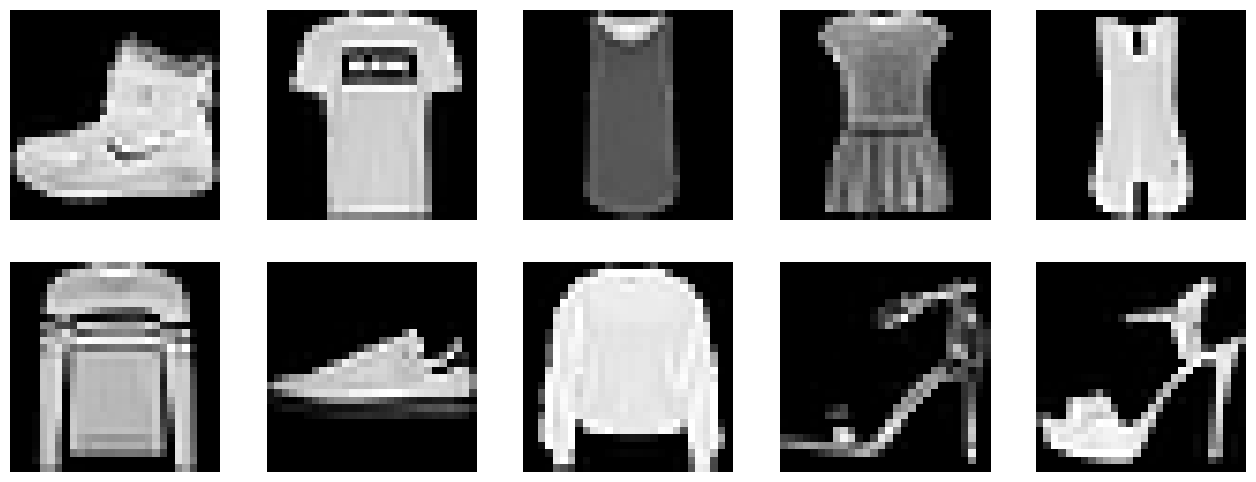

In [4]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = train_set.data[i,...]
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

<font color="blue">**Exercise 1**: When we loaded the Fashion-MNIST dataset we used the method `transforms.Compose`. Take a look at the documentation of [torchvision.transforms](https://pytorch.org/vision/0.8/transforms.html?highlight=transforms). Is there another transform that we can add to make our classification problem easier?</font>

---

*YOUR ANSWER HERE*

We can take advantage to normalise our data, and to resize images, in case they are in different sizes

---

# Dataloaders

Now we introduce a **critical piece in any deep learning training process**: the dataloader. In Pytorch we can create a dataloader for a given dataset as follows:


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0)

<font color="blue">**Exercise 2**: Take a look at the documentation of [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) and answer the following questions:</font>

<font color="blue">- What are the benefits of a dataloader?</font>

<font color="blue">- How can we make the dataloaders defined above better?</font>

---

*YOUR ANSWER HERE*

A dataloader makes life easy, because it manages a dataset, providing functions to sample from it (e.g. creating mini-batches) and iterate through the samples of the dataset.

An easy way to improve on the previously defined dataloaders, is to increase the batch size, and turn data shuffling on.

---

<font color="blue">**Exercise 3**: Now re-define the datasets and the dataloaders, and introduce normalisation (use the average of image means and stds of the training set for this), turn shuffling on, and use a batch size of 32.</font>

In [6]:
# Your Code Here

# First, let's calculate the average meand and standard deviation value over out training set
m = 0
s = 0
for img, label in train_set:
    m += img.mean()
    s += img.std()

m /= len(train_set)
s /= len(train_set)

In [7]:
# Your Code Here (cont)

# Define the transform, including normalisation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2860,), (0.3205,))])

# Redefine the datasets, with the new transform
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transform)
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=2)

# Define the model

<font color="blue">**Exercise 4**: Define the class for an MLP with two hidden layers using ReLU activations. The sizes of the input, output and hidden layers should be given during initialisation (using the `__init__()` class constructor parameters).</font>

In [8]:
# Your Code Here

class FCModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCModel, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            # Your code here
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

## Parameter Initialization

In PyTorch the default parameter initialization depends on the layer type. For example, for the Linear layer the default initialization is defined [here](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L87). Take a look and see if you recognize the initialization method.

You can find more initialization methods in the [`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html?highlight=init) module.

If necessary, you can change the default initialization of a layer as follows:

In [9]:
def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.ones_(w)

        if "bias" in name:
            nn.init.zeros_(w)

## Create the model and initialize its parameters

In [10]:
def get_n_params(model, learnable_only=True):
  """Utility function to count the number of parameters in a model"""
  n_params = [p.numel() for p in model.parameters() if (p.requires_grad or not(learnable_only))]
  return sum(n_params)

In [11]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel(input_size, 128, output_size)

print(f"Number of learnable parameters: {get_n_params(model)}")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

# WARNING! What are we doing here?
initialize_parameters(model)

Number of learnable parameters: 118282


## Define the train and validation methods

The following code should be easy to follow, but please note the following:

Here we use the function `torch.no_grad()` when we want to indicate to PyTorch that we do not want to calculate gradients. This saves a lot of computation and time, and we use it for example when we want to validate our model, when only forward calculations are needed. There are two ways to apply this function, and you can read about it here:
https://pytorch.org/docs/stable/generated/torch.no_grad.html

The way we use below is called a "decorator" function. It is a special super-power of python, and you can read more about it here:
https://realpython.com/primer-on-python-decorators/

Do not confuse `torch.no_grad()` with `model.eval()` and `model.train()`. The purpose of these two latter functions is to setup our model in different modes. This is very useful if you use layers that work in a different way during training and during evaluation, for example Dropout or Batch Normalisation. The model therefore needs to know how you are using it at any given time.

In [12]:
@torch.no_grad()  # prevent this function from computing gradients see https://pytorch.org/docs/stable/generated/torch.no_grad.html
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(target.view_as(pred)).sum().item()  # t1.view_as(t2) is equivalent to t1.view(t2.size())

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):

    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):

        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # print loss every N iterations
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

### The training loop

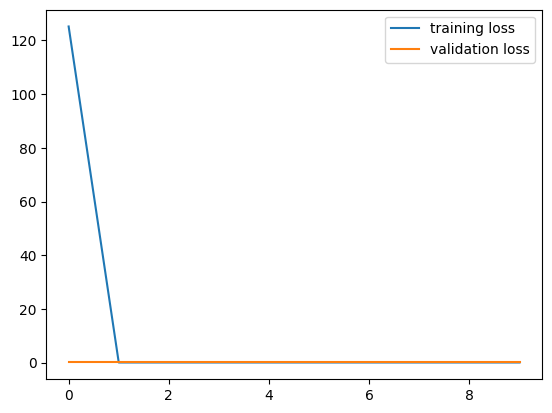

In [13]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)

    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

# Visualising Results

It may also be useful to visualize some qualitative examples of classification

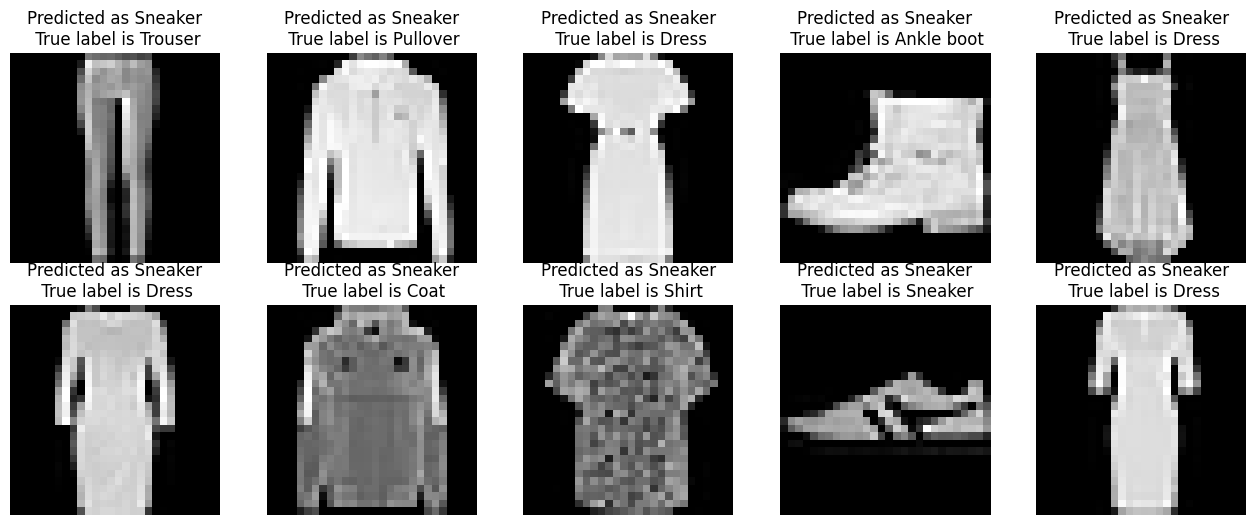

In [14]:
with torch.no_grad():

    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)

    data = data.view(-1, 28*28)
    output = model(data)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()

    plt.figure(figsize=(16, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        image = data[i,...].cpu().numpy().reshape((28,28))
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(val_set.classes[predictions[i]], val_set.classes[true[i]], ))

# Homework

> **Disclaimer:** The cells below contain repeated code from above. The reason why we are not following the fundamental [DRY principle](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) is for educational purposes to provide complete details in each cell.

<font color="blue">**Exercise 5**: Change the initialization of the model parameters (this will help a great deal) and train your model on the Fashion-MNIST dataset.</font>

In [15]:
# Your Code Here

# Parameter initialization with the Kaiming method

def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.kaiming_uniform_(w, nonlinearity='relu')

        if "bias" in name:
            nn.init.zeros_(w)


learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel(input_size, 128, output_size)

# move model to gpu if available
model.to(device)

# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

# initialize parameters with our own method
initialize_parameters(model)

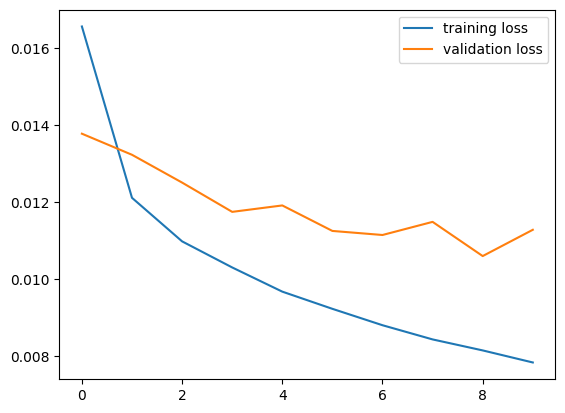

In [16]:
# Your Code Here (cont)

# the training loop

losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)

    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

In [17]:
# evaluate the trained model on the validation set
_ = validate(criterion, model, val_loader)


Test set: Average loss: 0.0113, Accuracy: 8703/10000 (87%)



<font color="blue">**Exercise 6**: Try to improve the Accuracy of your model on the validation set by adding more layers and/or more hidden units in you model. For example you can use a MLP with 2 hidden layers with 512 and 256 units respectively. You can also consider changing the batch size and learning rate if needed.</font>

In [18]:
def initialize_parameters(model):
  """Initalize Linear and BN layers"""
  for layer in model.network:
    if isinstance(layer, nn.Linear):
      nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
      nn.init.zeros_(layer.bias)
    elif isinstance(layer, nn.BatchNorm1d):
      # see https://github.com/pytorch/pytorch/blob/15be5483c0222ca9fbb596e011eec41ae4061bcc/torch/nn/modules/batchnorm.py#L51
      layer.reset_parameters()

In [19]:
def print_model_params(model):
  """Utility function to print out our model's parameters"""
  for id, layer in enumerate(model.network):
    print(f"({id})", layer)
    for name, p in layer.named_parameters():
      print("\t", name, p.numel())

In [20]:
# Your Code Here

# There are many possible configurations here
# In this example we use a model with three layers (with 256, 128, 64 neurons)
# and we add Batch Normalization and Dropout layers
# we also increase the batch size to 200 and the learning rate to 0.1.
#
dropout_prob = 0.2

class FCModel2(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FCModel2, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            # Your code here
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),
            torch.nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            torch.nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.BatchNorm1d(hidden_sizes[2]),
            nn.ReLU(),
            torch.nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_sizes[2], output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=200, shuffle=True, num_workers=2)

learning_rate = 0.1
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel2(input_size, (256,128,64), output_size)

# move model to gpu if available
model.to(device)

# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8, weight_decay=lambda_l2) # built-in L2

# initialize parameters with our own method
initialize_parameters(model)

In [21]:
print_model_params(model)

(0) Linear(in_features=784, out_features=256, bias=True)
	 weight 200704
	 bias 256
(1) BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
	 weight 256
	 bias 256
(2) ReLU()
(3) Dropout(p=0.2, inplace=False)
(4) Linear(in_features=256, out_features=128, bias=True)
	 weight 32768
	 bias 128
(5) BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
	 weight 128
	 bias 128
(6) ReLU()
(7) Dropout(p=0.2, inplace=False)
(8) Linear(in_features=128, out_features=64, bias=True)
	 weight 8192
	 bias 64
(9) BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
	 weight 64
	 bias 64
(10) ReLU()
(11) Dropout(p=0.2, inplace=False)
(12) Linear(in_features=64, out_features=10, bias=True)
	 weight 640
	 bias 10


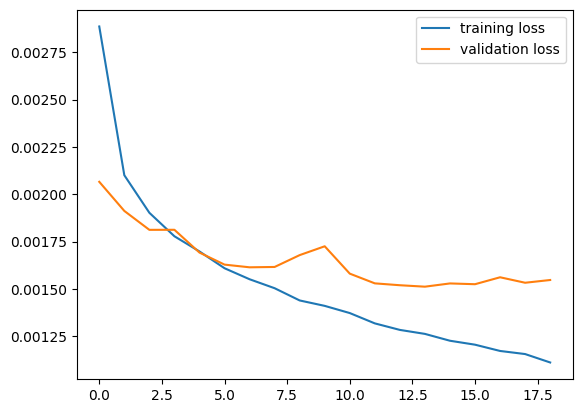

Early stopping
Best model found in epoch 13 restored.


In [22]:
# Your Code here (cont)

# Note the use of saving and loading the best-so-far model.
# See Early Stopping in Lecture 5 slides.

# the training loop
losses = {"train": [], "val": []}

best_err = np.Inf
wait = 0
patience = 5
best_epoch = -1

for epoch in range(25):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)

    losses["train"].append(train_loss)
    losses["val"].append(val_loss)

    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

    wait += 1
    if val_loss < best_err:
        best_err = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Best model so-far saved in epoch #{epoch}.")
        best_epoch = epoch
        wait = 0
    if wait >= patience:
        print("Early stopping")
        model = FCModel2(input_size, (256, 128, 64), output_size)
        model.load_state_dict(torch.load("best_model.pt", weights_only=True))
        model.to(device)
        print(f"Best model found in epoch {best_epoch} restored.")
        break

In [23]:
# evaluate the trained model on the validation set
_ = validate(criterion, model, val_loader)


Test set: Average loss: 0.0015, Accuracy: 8956/10000 (90%)



<font color="blue">**Exercise 7**: Try at least two different [optimizers](https://pytorch.org/docs/stable/optim.html#algorithms) (e.g. SGD with momentum, RMSProp, Adam, etc.) and plot **in a single matplotlib figure** the loss curves for training the model with them. We want them in a single figure to be able to easily compare the three learning curves.</font>

In [24]:
# Your code here

# save the previous loss values (SGD with momentum) to plot them later
all_losses = [losses.copy()]


torch.manual_seed(0) # seed for reproductibility
model = FCModel2(input_size, (256, 128, 64), output_size)
model.to(device)

# RMSProp with default parameters
optimizer = optim.RMSprop(model.parameters())

# initialize parameters with our own method
initialize_parameters(model)

# training loop
losses = {"train": [], "val": []}
for epoch in range(25):
    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)

all_losses.append(losses.copy())



torch.manual_seed(0) # seed for reproductibility
model = FCModel2(input_size, (256, 128, 64), output_size)
model.to(device)

# Adam with default parameters
optimizer = optim.Adam(model.parameters())

# initialize parameters with our own method
initialize_parameters(model)

# training loop
losses = {"train": [], "val": []}
for epoch in range(25):
    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)

all_losses.append(losses.copy())

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.974285
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.453817
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.328397

Test set: Average loss: 0.0022, Accuracy: 8412/10000 (84%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.395343
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.406811
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.332845

Test set: Average loss: 0.0019, Accuracy: 8586/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.316376
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.393807
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.302190

Test set: Average loss: 0.0018, Accuracy: 8687/10000 (87%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.273639
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.295832
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.369956

Test set: Average loss: 0.0018, Accuracy: 8638/10000 (86%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.288436
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.355020
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.372349

Test set: Average loss: 0.0017

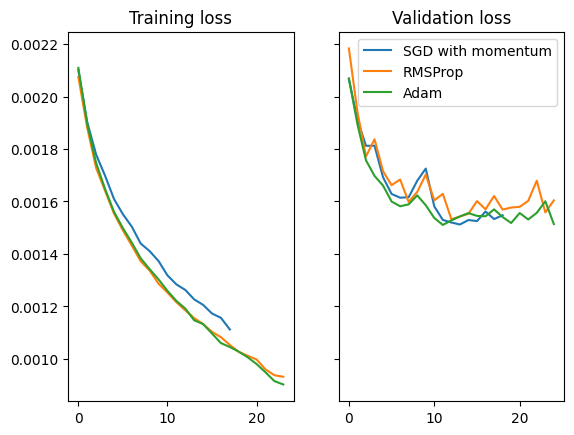

In [25]:
# Your Code Here (cont)

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_title('Training loss')
#discard the first value because it is usually very large
ax1.plot(all_losses[0]["train"][1:], label="SGD with momentum")
ax1.plot(all_losses[1]["train"][1:], label="RMSProp")
ax1.plot(all_losses[2]["train"][1:], label="Adam")

ax2.set_title('Validation loss')
ax2.plot(all_losses[0]["val"], label="SGD with momentum")
ax2.plot(all_losses[1]["val"], label="RMSProp")
ax2.plot(all_losses[2]["val"], label="Adam")

plt.legend()
plt.show()

<font color="blue">**Exercise 8**: Calculate the Accuracy for each individual class in the dataset and plot the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix) of your trained models.</font>

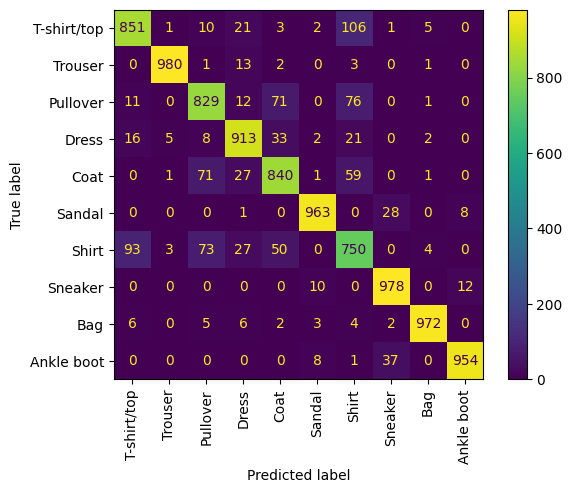

In [26]:
# Your code here

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()  # prevent this function from computing gradients
def evaluate(model, loader):

    predictions = []
    true = []

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)
        output = model(data)
        predictions += np.argmax(output.cpu().numpy(), axis=1).tolist()
        true += target.cpu().numpy().tolist()

    return true, predictions

true, pred = evaluate(model, val_loader)
cm = confusion_matrix(true, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_set.classes)
disp.plot(xticks_rotation='vertical')